In [1]:
import pandas as pd
import numpy as np
import joblib
import time
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix, load_npz
from sklearn.preprocessing import LabelEncoder

In [2]:
# --- Genel Ayarlar ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Dosya Yollarının Tanımlanması ---
PROCESSED_TEXT_DATA_PATH = './datas/manuel_feature_extracted.csv'
TFIDF_FEATURES_PATH = './saved_objects/tfidf_features.npz'
EXTRA_SENTIMENT_PIPE_PATH = './saved_objects/pipe_extra_sentiment.joblib'
MODELS_DIR_NORMAL = './models-yontem-1/'
MODELS_DIR_ENHANCED = './models-yontem-1'

In [3]:
# Eğitimde kaydedilen model adları
model_files = {
    # Normal Modeller
    'ExtraTrees_normal': 'best_extra_trees.pkl',
    'MLP_normal': 'best_mlp.pkl',
    'RandomForest_normal': 'best_rf.pkl',
    'XGBoost_normal': 'best_xgb_sklearn.pkl',
    'LinearSVC_normal': 'best_lsvc.pkl',
    'LogisticRegression_normal': 'best_logreg.pkl',
    'MultinomialNB_normal': 'best_nb.pkl',
    # Geliştirilmiş (Enhanced) Modeller
    'ExtraTrees_enhanced': 'et_enhanced.pkl',
    'MLP_enhanced': 'mlp_enhanced.pkl',
    'RandomForest_enhanced': 'rf_enhanced.pkl',
    'XGBoost_enhanced': 'xgb_enhanced_sklearn.pkl',
    'LinearSVC_enhanced': 'lsvc_enhanced.pkl',
    'LogisticRegression_enhanced': 'lr_enhanced.pkl',
    'MultinomialNB_enhanced': 'mnb_enhanced.pkl',
}

In [4]:
def prepare_test_data():
    """
    Önceden işlenmiş ve kaydedilmiş öznitelikleri yükleyerek
    Normal ve Enhanced test setlerini oluşturur ve döndürür.
    """
    print(">>> Veri Hazırlama Süreci Başlatılıyor...")
    try:
        features_df = pd.read_csv(PROCESSED_TEXT_DATA_PATH)
        tfidf_features = load_npz(TFIDF_FEATURES_PATH)
        print(f"'{PROCESSED_TEXT_DATA_PATH}' ve '{TFIDF_FEATURES_PATH}' başarıyla yüklendi.")

        numeric_cols = ['explicitly_contains_entity', 'ctx_neg', 'ctx_neu', 'ctx_pos', 'ctx_compound', 'emb_sim', 'fuzzy_max']
        manual_numeric_features = features_df[numeric_cols].fillna(0).astype(float).values
        X_normal = hstack([tfidf_features, csr_matrix(manual_numeric_features)], format='csr')
        Y = features_df['Sentiment']
        print(f"Normal öznitelik matrisi (X_normal) oluşturuldu. Boyut: {X_normal.shape}")

        pipe_extra = joblib.load(EXTRA_SENTIMENT_PIPE_PATH)
        probas_main = pipe_extra.predict_proba(features_df['processed_text'].fillna(''))
        X_enhanced = hstack([X_normal, csr_matrix(probas_main)], format='csr')
        print(f"Enhanced öznitelik matrisi (X_enhanced) oluşturuldu. Boyut: {X_enhanced.shape}")

        _, X_test_normal, _, y_test_normal = train_test_split(X_normal, Y, test_size=0.20, random_state=42, stratify=Y)
        _, X_test_enhanced, _, y_test_enhanced = train_test_split(X_enhanced, Y, test_size=0.20, random_state=42, stratify=Y)
        
        print("Test setleri başarıyla oluşturuldu.\n")
        return X_test_normal, X_test_enhanced, y_test_normal

    except FileNotFoundError as e:
        print(f"\nHATA: Gerekli dosya bulunamadı! - {e}")
        return None, None, None
    except Exception as e:
        print(f"\nBEKLENMEDİK BİR HATA OLUŞTU: {e}")
        return None, None, None

In [5]:
def evaluate_model(model, model_name, X_test, y_test):
    """Bir modeli değerlendirir, sonuçları yazdırır ve metrikleri döndürür."""
    print(f"\n{'='*25} {model_name} Test Sonuçları {'='*25}")
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    # --- ALTERNATİF YÖNTEM ---
    y_true_for_metrics = y_test
    y_pred_for_metrics = y_pred
    display_labels = None

    # Eğer tahminler sayısal ise, gerçek etiketleri de sayısala çevir ve karşılaştır.
    if pd.api.types.is_numeric_dtype(pd.Series(y_pred)):
        print("Model sayısal tahminler üretti. Gerçek etiketler (y_test) de karşılaştırma için sayısala dönüştürülüyor...")
        
        # Sadece bu test anı için bir LabelEncoder oluştur
        le_for_test = LabelEncoder()
        
        # Encoder'ı gerçek metin etiketlerine (y_test) göre eğit
        y_true_for_metrics = le_for_test.fit_transform(y_test)
        
        # Raporlama için metin etiketlerini al
        display_labels = le_for_test.classes_

    # Metrikleri hesapla
    accuracy = accuracy_score(y_true_for_metrics, y_pred_for_metrics)
    f1 = f1_score(y_true_for_metrics, y_pred_for_metrics, average='macro')

    print(f"Tahmin Süresi: {end_time - start_time:.4f} saniye")
    print(f"Test Doğruluk (Accuracy): {accuracy:.4f}")
    print(f"Test Makro F1-Skoru: {f1:.4f}")
    print("\nSınıflandırma Raporu:")
    # Rapor için orijinal metin etiketlerini kullanmak daha okunaklı olur.
    # Bu yüzden orijinal y_test ve dönüştürülmüş y_pred'i kullanırız.
    # Eğer y_pred sayısal ise, onu da metne geri çevirmemiz gerekir.
    if display_labels is not None: # Eğer dönüşüm yapıldıysa
        y_pred_str = display_labels[y_pred]
        print(classification_report(y_test, y_pred_str, target_names=display_labels))
    else: # Eğer dönüşüm yapılmadıysa (ikisi de string ise)
        print(classification_report(y_test, y_pred))


    # Karışıklık Matrisini Çizdir
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(y_true_for_metrics, y_pred_for_metrics, 
                                            display_labels=display_labels,
                                            cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    ax.set_title(f'{model_name} - Test Seti Karışıklık Matrisi')
    plt.tight_layout()
    plt.show()
    
    return {'Model': model_name, 'Accuracy': accuracy, 'F1 Macro': f1}

>>> Veri Hazırlama Süreci Başlatılıyor...
'./datas/manuel_feature_extracted.csv' ve './saved_objects/tfidf_features.npz' başarıyla yüklendi.
Normal öznitelik matrisi (X_normal) oluşturuldu. Boyut: (73995, 5007)
Enhanced öznitelik matrisi (X_enhanced) oluşturuldu. Boyut: (73995, 5013)
Test setleri başarıyla oluşturuldu.

>>> Kaydedilmiş modeller yükleniyor...
Model yükleme işlemi tamamlandı.


========================= ExtraTrees_normal Test Sonuçları =========================
Tahmin Süresi: 1.1181 saniye
Test Doğruluk (Accuracy): 0.8942
Test Makro F1-Skoru: 0.8916

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.90      0.85      0.87      2575
    Negative       0.91      0.91      0.91      4472
     Neutral       0.88      0.88      0.88      3621
    Positive       0.88      0.91      0.90      4131

    accuracy                           0.89     14799
   macro avg       0.89      0.89      0.89     14799
weighted avg       0.89   

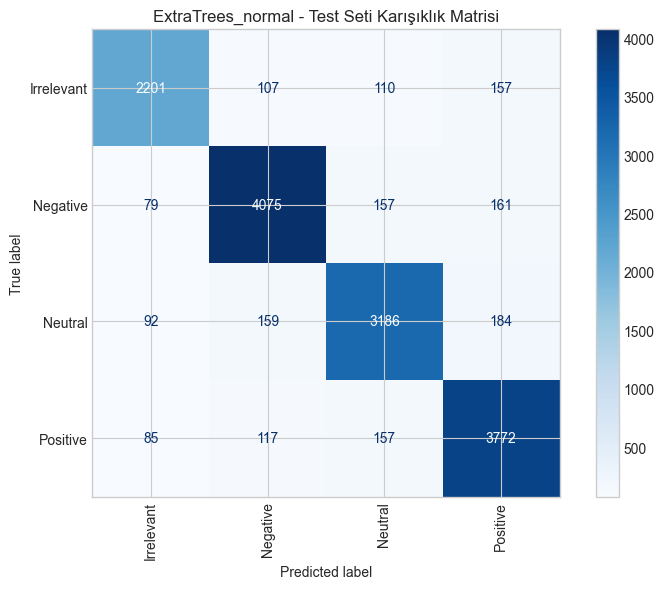


========================= MLP_normal Test Sonuçları =========================
Tahmin Süresi: 0.0970 saniye
Test Doğruluk (Accuracy): 0.7985
Test Makro F1-Skoru: 0.7927

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.72      0.78      0.75      2575
    Negative       0.84      0.83      0.84      4472
     Neutral       0.79      0.77      0.78      3621
    Positive       0.81      0.80      0.81      4131

    accuracy                           0.80     14799
   macro avg       0.79      0.79      0.79     14799
weighted avg       0.80      0.80      0.80     14799



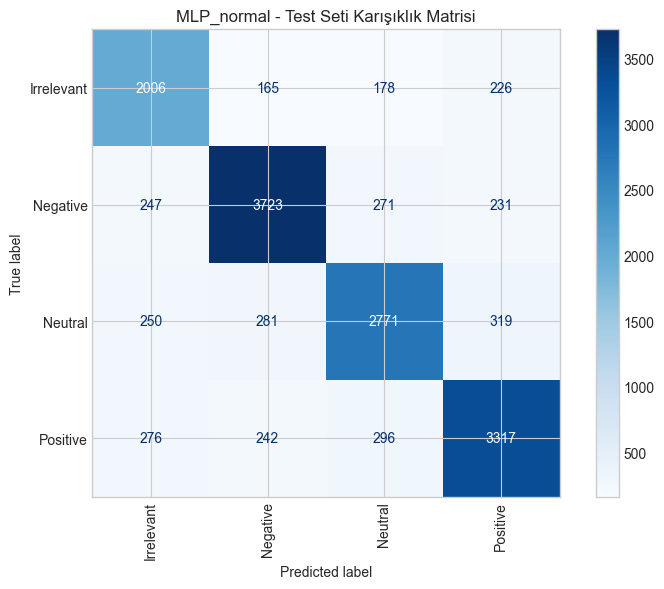


========================= RandomForest_normal Test Sonuçları =========================
Tahmin Süresi: 0.1913 saniye
Test Doğruluk (Accuracy): 0.7701
Test Makro F1-Skoru: 0.7642

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.74      0.71      0.72      2575
    Negative       0.80      0.81      0.80      4472
     Neutral       0.75      0.74      0.75      3621
    Positive       0.77      0.79      0.78      4131

    accuracy                           0.77     14799
   macro avg       0.77      0.76      0.76     14799
weighted avg       0.77      0.77      0.77     14799



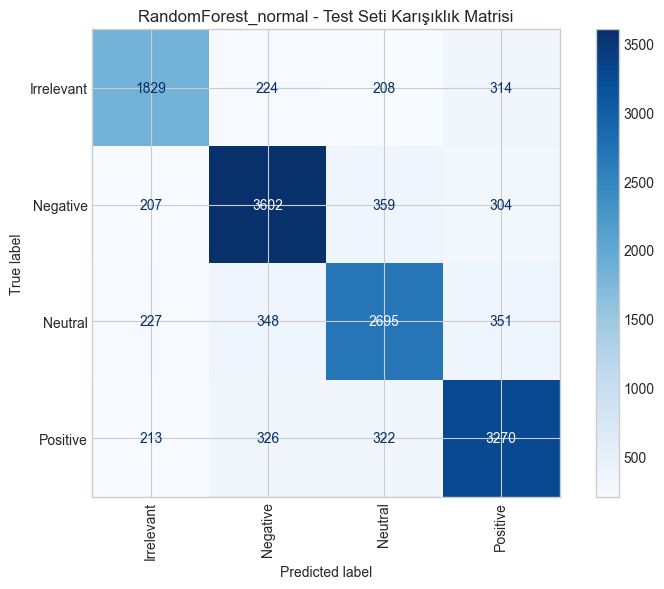


========================= XGBoost_normal Test Sonuçları =========================
Model sayısal tahminler üretti. Gerçek etiketler (y_test) de karşılaştırma için sayısala dönüştürülüyor...
Tahmin Süresi: 0.2569 saniye
Test Doğruluk (Accuracy): 0.6874
Test Makro F1-Skoru: 0.6776

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.54      0.65      0.59      2575
    Negative       0.76      0.74      0.75      4472
     Neutral       0.69      0.63      0.66      3621
    Positive       0.72      0.70      0.71      4131

    accuracy                           0.69     14799
   macro avg       0.68      0.68      0.68     14799
weighted avg       0.69      0.69      0.69     14799



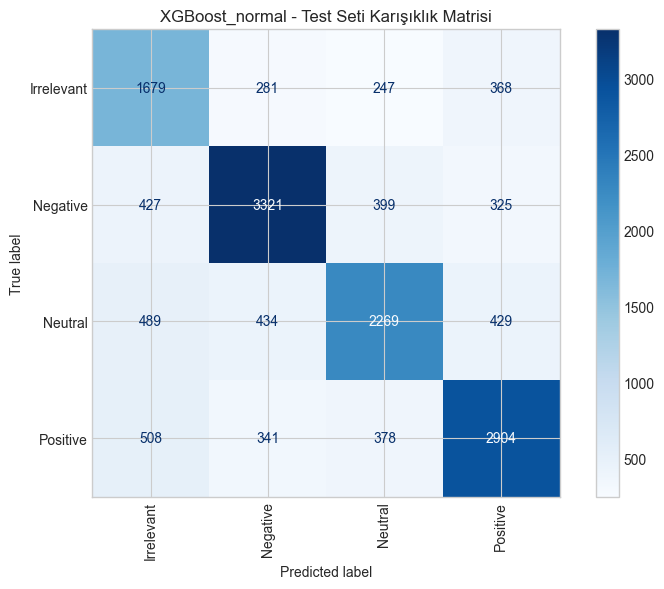


========================= LinearSVC_normal Test Sonuçları =========================
Tahmin Süresi: 0.0030 saniye
Test Doğruluk (Accuracy): 0.6879
Test Makro F1-Skoru: 0.6797

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.56      0.68      0.61      2575
    Negative       0.77      0.73      0.75      4472
     Neutral       0.67      0.63      0.65      3621
    Positive       0.72      0.70      0.71      4131

    accuracy                           0.69     14799
   macro avg       0.68      0.68      0.68     14799
weighted avg       0.69      0.69      0.69     14799



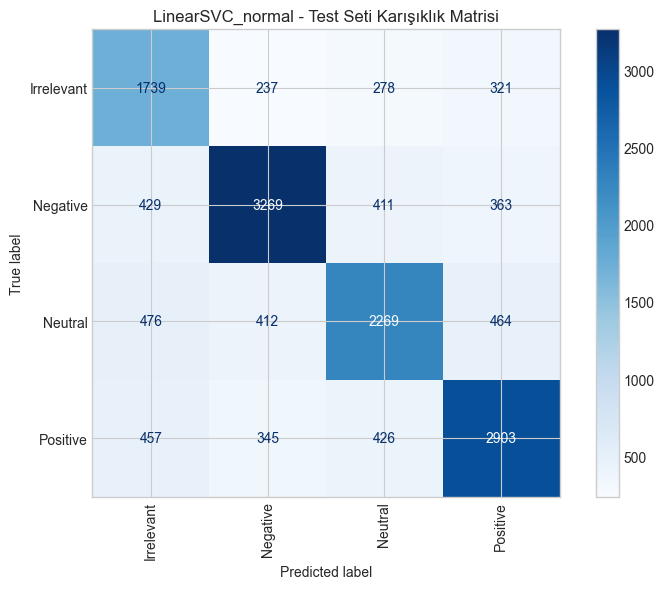


========================= LogisticRegression_normal Test Sonuçları =========================
Tahmin Süresi: 0.0030 saniye
Test Doğruluk (Accuracy): 0.6812
Test Makro F1-Skoru: 0.6729

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.55      0.67      0.60      2575
    Negative       0.76      0.73      0.75      4472
     Neutral       0.67      0.62      0.64      3621
    Positive       0.71      0.69      0.70      4131

    accuracy                           0.68     14799
   macro avg       0.67      0.68      0.67     14799
weighted avg       0.69      0.68      0.68     14799



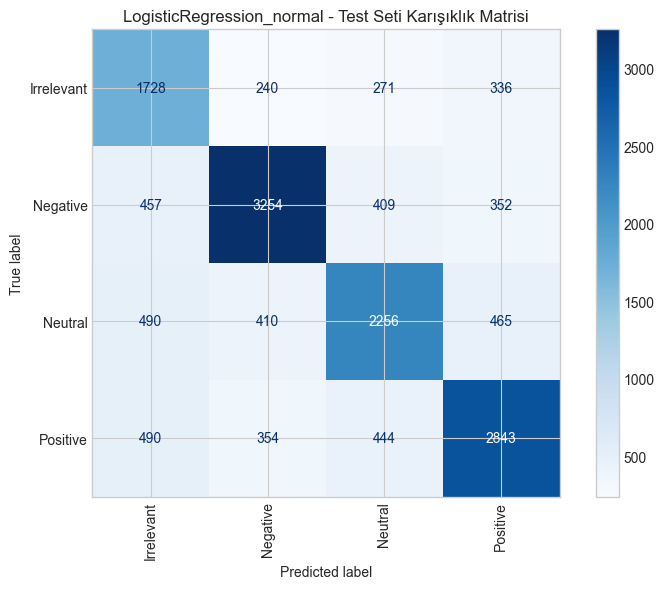


Not: MultinomialNB_normal için özel öznitelik seti kullanılmıyor, bu değerlendirme atlanmıştır.

========================= ExtraTrees_enhanced Test Sonuçları =========================
Tahmin Süresi: 0.9154 saniye
Test Doğruluk (Accuracy): 0.8839
Test Makro F1-Skoru: 0.8816

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.91      0.83      0.87      2575
    Negative       0.90      0.91      0.90      4472
     Neutral       0.88      0.86      0.87      3621
    Positive       0.86      0.91      0.89      4131

    accuracy                           0.88     14799
   macro avg       0.89      0.88      0.88     14799
weighted avg       0.88      0.88      0.88     14799



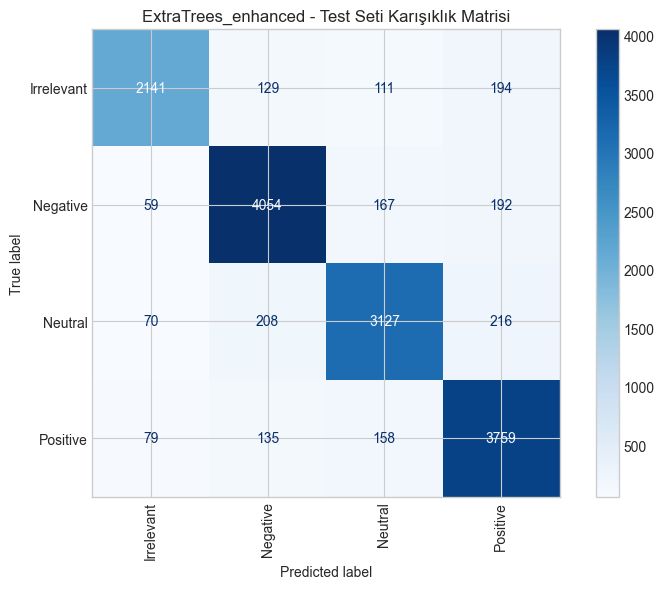


========================= MLP_enhanced Test Sonuçları =========================
Tahmin Süresi: 0.0769 saniye
Test Doğruluk (Accuracy): 0.7884
Test Makro F1-Skoru: 0.7826

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.71      0.78      0.74      2575
    Negative       0.82      0.84      0.83      4472
     Neutral       0.79      0.75      0.77      3621
    Positive       0.81      0.78      0.79      4131

    accuracy                           0.79     14799
   macro avg       0.78      0.78      0.78     14799
weighted avg       0.79      0.79      0.79     14799



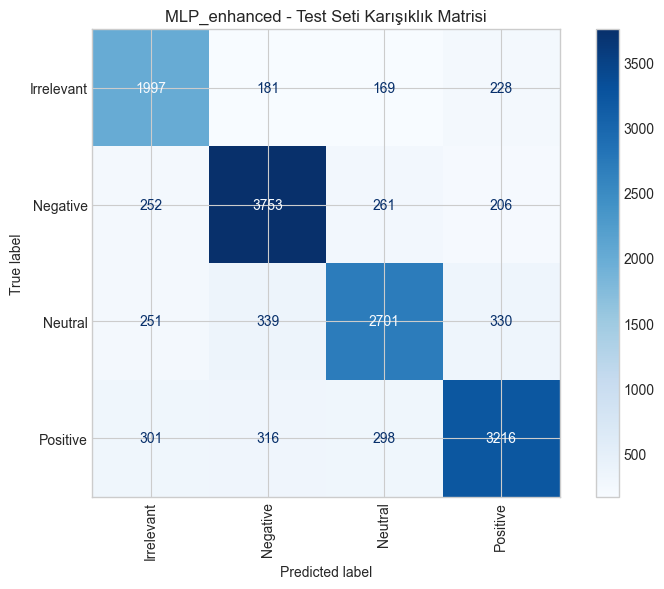


========================= XGBoost_enhanced Test Sonuçları =========================
Model sayısal tahminler üretti. Gerçek etiketler (y_test) de karşılaştırma için sayısala dönüştürülüyor...
Tahmin Süresi: 0.2250 saniye
Test Doğruluk (Accuracy): 0.6971
Test Makro F1-Skoru: 0.6873

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.58      0.64      0.61      2575
    Negative       0.76      0.75      0.75      4472
     Neutral       0.69      0.64      0.66      3621
    Positive       0.72      0.72      0.72      4131

    accuracy                           0.70     14799
   macro avg       0.69      0.69      0.69     14799
weighted avg       0.70      0.70      0.70     14799



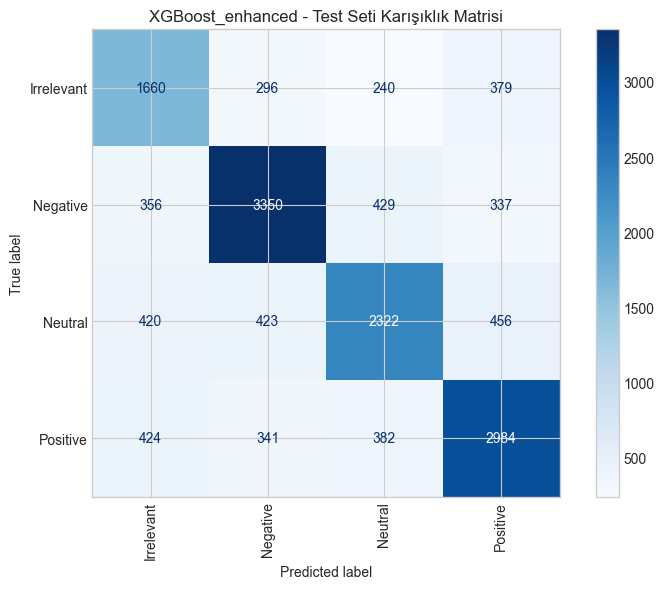


========================= LinearSVC_enhanced Test Sonuçları =========================
Tahmin Süresi: 0.0019 saniye
Test Doğruluk (Accuracy): 0.6863
Test Makro F1-Skoru: 0.6784

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.56      0.68      0.61      2575
    Negative       0.76      0.73      0.74      4472
     Neutral       0.68      0.63      0.65      3621
    Positive       0.71      0.69      0.70      4131

    accuracy                           0.69     14799
   macro avg       0.68      0.68      0.68     14799
weighted avg       0.69      0.69      0.69     14799



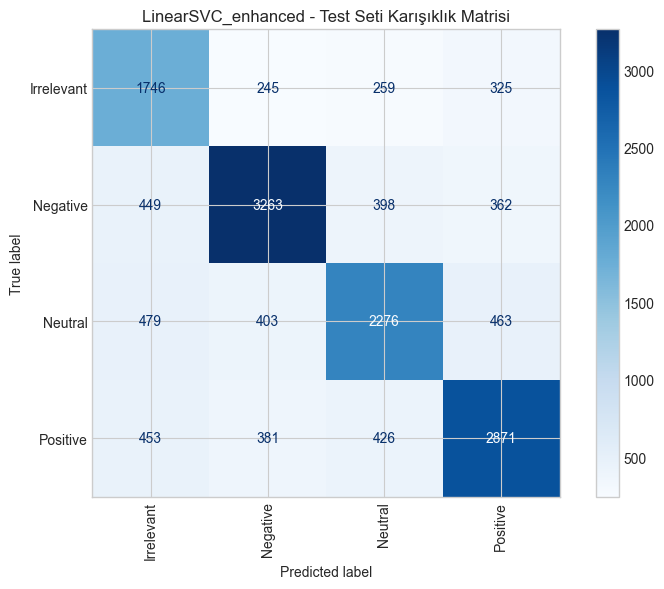


========================= LogisticRegression_enhanced Test Sonuçları =========================
Tahmin Süresi: 0.0021 saniye
Test Doğruluk (Accuracy): 0.6796
Test Makro F1-Skoru: 0.6714

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Irrelevant       0.55      0.67      0.60      2575
    Negative       0.76      0.72      0.74      4472
     Neutral       0.66      0.62      0.64      3621
    Positive       0.71      0.69      0.70      4131

    accuracy                           0.68     14799
   macro avg       0.67      0.68      0.67     14799
weighted avg       0.69      0.68      0.68     14799



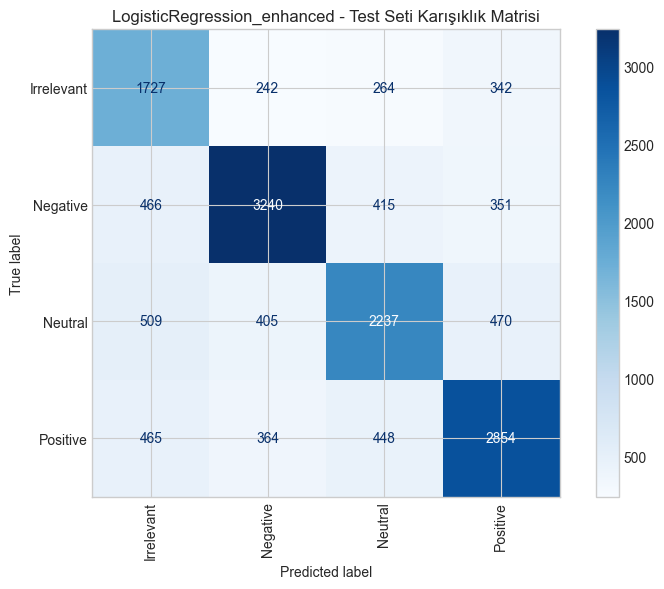


Not: MultinomialNB_enhanced için özel öznitelik seti kullanılmıyor, bu değerlendirme atlanmıştır.


          ### TÜM MODELLERİN TEST SETİ PERFORMANS ÖZETİ ###           
                          Model  Accuracy  F1 Macro
0             ExtraTrees_normal  0.894250  0.891556
1           ExtraTrees_enhanced  0.883911  0.881639
2                    MLP_normal  0.798500  0.792689
3                  MLP_enhanced  0.788364  0.782639
4           RandomForest_normal  0.770052  0.764152
5              XGBoost_enhanced  0.697074  0.687338
6              LinearSVC_normal  0.687884  0.679667
7            LinearSVC_enhanced  0.686263  0.678392
8                XGBoost_normal  0.687411  0.677594
9     LogisticRegression_normal  0.681195  0.672922
10  LogisticRegression_enhanced  0.679641  0.671363


In [ ]:
# 1. Test verisini hazırla
X_test_normal, X_test_enhanced, y_test = prepare_test_data()

if X_test_normal is not None:
    # 2. Modelleri yükle
    loaded_models = {}
    print(">>> Kaydedilmiş modeller yükleniyor...")
    for model_name, file_name in model_files.items():
        if 'enhanced' in model_name:
            model_path = os.path.join(MODELS_DIR_ENHANCED, file_name)
        else:
            model_path = os.path.join(MODELS_DIR_NORMAL, file_name)
        try:
            loaded_models[model_name] = joblib.load(model_path)
        except FileNotFoundError:
            print(f"- UYARI: {model_name} modeli ({model_path}) bulunamadı!")
            loaded_models[model_name] = None
    print("Model yükleme işlemi tamamlandı.\n")

    # 3. Modelleri değerlendir
    results_list = []
    for model_name, model_obj in loaded_models.items():
        if model_obj is None:
            continue

        if 'MultinomialNB' in model_name:
            print(f"\nNot: {model_name} için özel öznitelik seti kullanılmıyor, bu değerlendirme atlanmıştır.")
            continue

        if 'normal' in model_name:
            result = evaluate_model(model_obj, model_name, X_test_normal, y_test)
        elif 'enhanced' in model_name:
            result = evaluate_model(model_obj, model_name, X_test_enhanced, y_test)
        
        if result:
            results_list.append(result)

    # 4. Sonuçları özetle
    if results_list:
        results_df = pd.DataFrame(results_list)
        results_df = results_df.sort_values(by='F1 Macro', ascending=False).reset_index(drop=True)
        print("\n\n" + "="*70)
        print("### TÜM MODELLERİN TEST SETİ PERFORMANS ÖZETİ ###".center(70))
        print("="*70)
        print(results_df.to_string())
        print("="*70)